# Experiments

These notebook is intended to retrieve the data from the experiments data contained in the CSV files that are generated automatically. It assumes some naming convention for the files that the user has to follow manually. The next cell contains all the code necessary for any experiment.

In [243]:
##
## MODULES
##

from matplotlib import pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import os

##
## GLOBAL VARIABLES
## 

contexts_file = "contexts.txt"
results_folder = "results"
images_folder = "images"

save_images = True

results_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime",
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
    "AddedTraditionalObjects",
    "AddedIndirectObjects",
    "ChunksLoaded",
    "ObjectPlacesGenerated",
]

time_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime",
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
]

traditional_time_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime"
]

indirect_update_time_columns = [
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime"
]

indirect_batch_time_columns = [
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime"
]

indirect_buffer_time_columns = [
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime"
]

indirect_time_columns = [
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime"
]

##
## GLOBAL FUNCTIONS
##

def get_contexts():
    file_path = os.path.join('contexts.txt')
    contexts = []
    
    with open(file_path, 'r') as file:
        content = file.read().strip().split('@@@@@@@@')
        
        for context in content:
            if len(context) == 0:
                continue
            
            context_dict = {}
            
            for line in context.split('\n'):
                if line.strip():
                    key, value = line.split(':', 1)
                    context_dict[key.strip()] = value.strip()
                    
            contexts.append(context_dict)
            
    return contexts

def get_results(contexts):
    for context in contexts:
        result_path = context.get("ResultPath")
        if result_path and os.path.exists(result_path):
            context["Result"] = pd.read_csv(result_path)
            context["Result"].columns = results_columns
        else:
            context["Result"] = None
    return contexts

def cast_int_contexts(contexts, key):
    for context in contexts:
        context[key] = int(context[key])
    

def filter_contexts(contexts, key, value):
    filtered_contexts = []
    
    for context in contexts:
        if context[key] == value:
            filtered_contexts.append(context)
            
    return filtered_contexts

def filter_contexts_k(contexts, key1, key2):
    filtered_contexts = []
    
    for context in contexts:
        if context[key1] == context[key2]:
            filtered_contexts.append(context)
            
    return filtered_contexts
    

def get_merged_contexts_results(contexts, merge_column_name):
    dataframes = []

    for context in contexts:
        context["Result"][merge_column_name] = context[merge_column_name]
        dataframes.append(context["Result"])

    if len(contexts) > 0:
        merged_df = pd.concat(dataframes, ignore_index=True)
        merged_df = merged_df[[merge_column_name] + results_columns]
    
        return merged_df
    
    raise Exception("get_merged_contexts_results: no contexts provided") 

def get_mili_times_df(df):
    for col in time_columns:
        if col in df.columns:
            df[col] = (df[col] / 1000).round(2)

def add_sum_column(df, column_name, columns_to_sum):
    df[column_name] = df[columns_to_sum].sum(axis=1)
    return df

def add_division_denominator_column(df, column_name, enumerator, denominator_column):
    df[column_name] = (enumerator / df[denominator_column])

##
## PLOTING FUNCTIONS
##

def generate_line_plot(dfs, column, labels, title, xlabel, ylabel, log2scale=False):
    fig, ax = plt.subplots()

    for i in range(len(dfs)):
        ax.plot(dfs[i].index, dfs[i][column], label=labels[i])
        
    if log2scale:
        ax.set_xscale('log', base=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if len(labels) > 1:
        ax.legend()
    
    plt.title(title)

    if save_images:
        log2scale_text = "-Log2" if log2scale else ""
        plt.savefig(images_folder + "/" + title + log2scale_text + ".png")
    
    plt.show()

##
## GLOBAL LOGIC
##

contexts = get_contexts()

get_results(contexts)

print(f"Loaded {len(contexts)} experiment contexts successfully")


Loaded 58 experiment contexts successfully


## Objects

Average statistics per frame when running an application with a permanent amount of objects

In [244]:
experiment = "Objects"

experiment_contexts = filter_contexts(contexts, "Experiment", experiment)

cast_int_contexts(experiment_contexts, "NumberOfObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingTransformObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMeshObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialTypeObjects")

### No Changing Objects

Experiments with an static amount of objects that don't suffer any type of change

3.9752609752609755


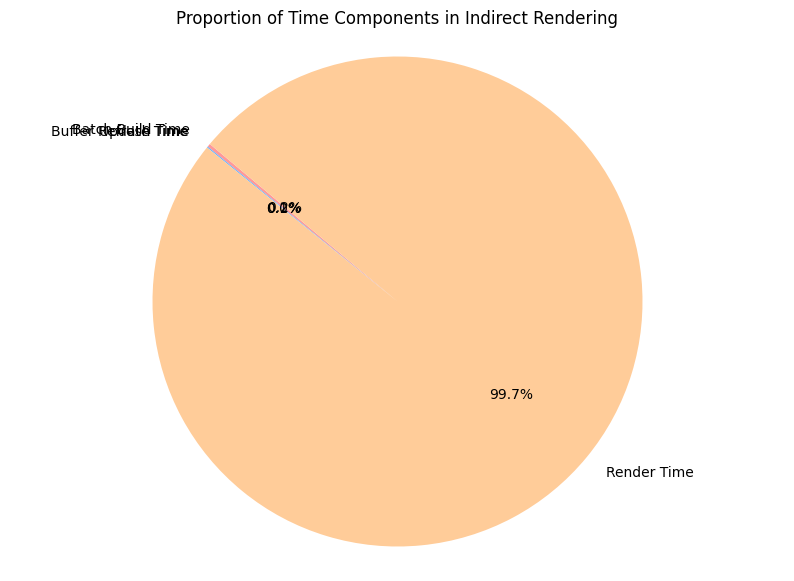

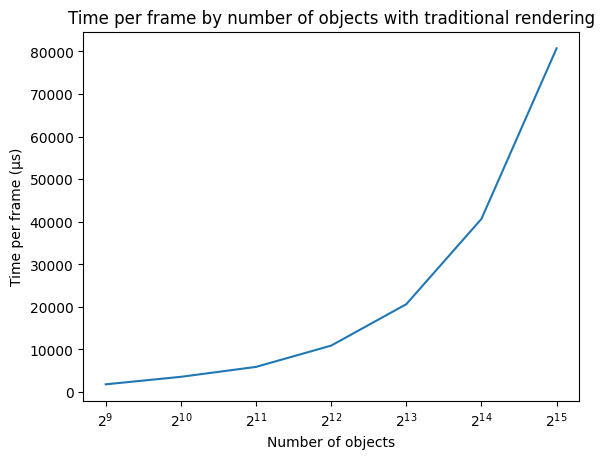

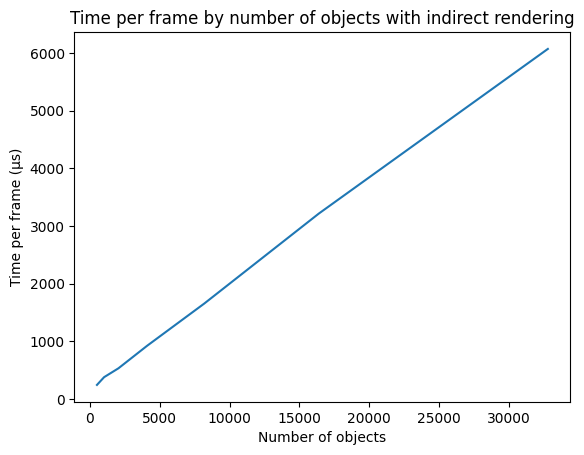

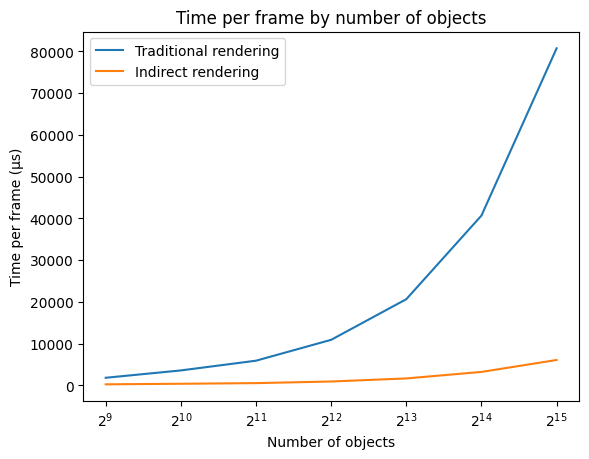

In [253]:
no_changing_contexts = filter_contexts(experiment_contexts, "NumberOfChangingTransformObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMeshObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialTypeObjects", 0)

no_changing_traditional_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Traditional")
no_changing_indirect_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Indirect")


no_changing_traditional_results = get_merged_contexts_results(no_changing_traditional_contexts, "NumberOfObjects")
no_changing_indirect_results = get_merged_contexts_results(no_changing_indirect_contexts, "NumberOfObjects")

no_traditional_avg = no_changing_traditional_results.groupby("NumberOfObjects").mean()
no_indirect_avg = no_changing_indirect_results.groupby("NumberOfObjects").mean()

add_sum_column(no_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(no_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(no_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(no_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(no_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(no_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(no_indirect_avg, "FPS", 1_000_000, "FrameTime")

print(no_indirect_avg["BatchBuildTime"].mean())

# Calculate the mean times for the components of indirect rendering
batch_time = no_indirect_avg["BatchBuildTime"].mean()
buffer_time = no_indirect_avg["BufferRefreshTime"].mean()
update_time = no_indirect_avg["UpdateTime"].mean()
render_time = no_indirect_avg["IndirectSceneRenderTime"].mean()

labels = ["Batch Build Time", "Buffer Refresh Time", "Update Time", "Render Time"]
sizes = [batch_time, buffer_time, update_time, render_time]
colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99"]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Time Components in Indirect Rendering")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

generate_line_plot([no_traditional_avg],
                   "FrameTime",
                   ["Traditional rendering"],
                   "Time per frame by number of objects with traditional rendering",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

generate_line_plot([no_indirect_avg],
                   "FrameTime",
                   ["Indirect rendering"],
                   "Time per frame by number of objects with indirect rendering",
                   "Number of objects",
                   "Time per frame (μs)")

generate_line_plot([no_traditional_avg, no_indirect_avg],
                   "FrameTime",
                   ["Traditional rendering", "Indirect rendering"],
                   "Time per frame by number of objects",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)



### Transform Changing Objects

3.9752609752609755


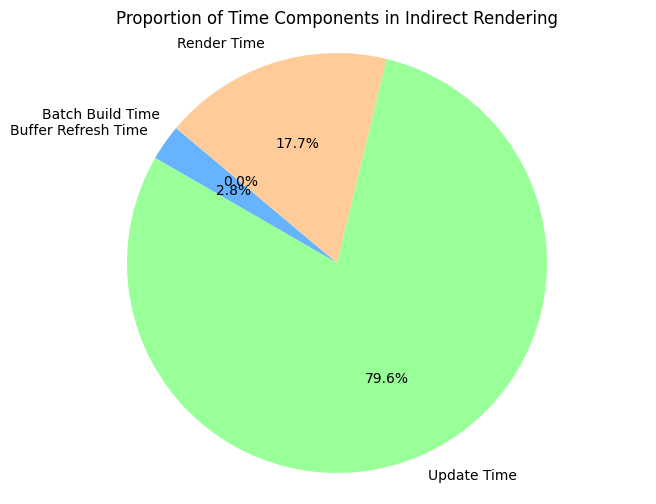

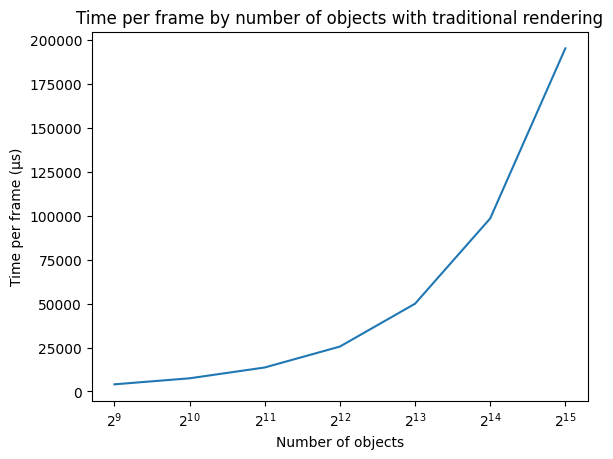

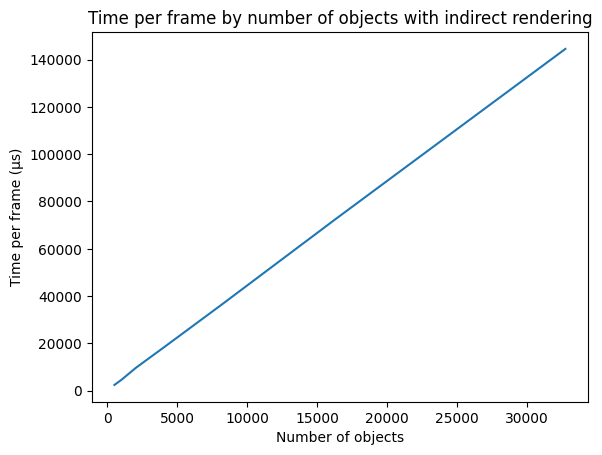

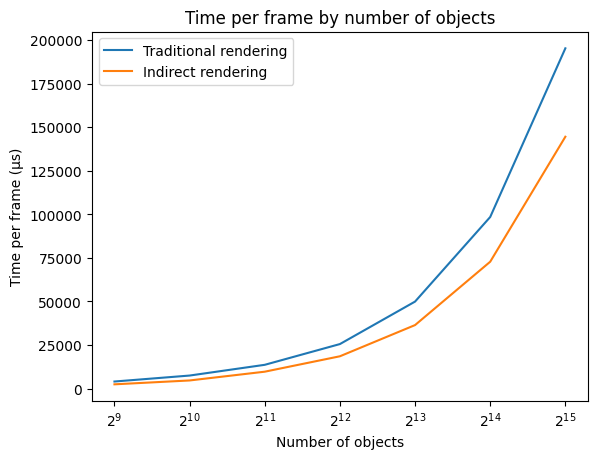

In [257]:
tr_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingTransformObjects")

tr_changing_traditional_contexts = filter_contexts(tr_changing_contexts, "ObjectRenderingMethod", "Traditional")
tr_changing_indirect_contexts = filter_contexts(tr_changing_contexts, "ObjectRenderingMethod", "Indirect")

tr_changing_traditional_results = get_merged_contexts_results(tr_changing_traditional_contexts, "NumberOfObjects")
tr_changing_indirect_results = get_merged_contexts_results(tr_changing_indirect_contexts, "NumberOfObjects")

tr_traditional_avg = tr_changing_traditional_results.groupby("NumberOfObjects").mean()
tr_indirect_avg = tr_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(tr_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(tr_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(tr_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(tr_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(tr_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(tr_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(tr_indirect_avg, "FPS", 1_000_000, "FrameTime")


print(no_indirect_avg["BatchBuildTime"].mean())

# Calculate the mean times for the components of indirect rendering
batch_time = tr_indirect_avg["BatchBuildTime"].mean()
buffer_time = tr_indirect_avg["BufferRefreshTime"].mean()
update_time = tr_indirect_avg["UpdateTime"].mean()
render_time = tr_indirect_avg["IndirectSceneRenderTime"].mean()

labels = ["Batch Build Time", "Buffer Refresh Time", "Update Time", "Render Time"]
sizes = [batch_time, buffer_time, update_time, render_time]
colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Time Components in Indirect Rendering")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

generate_line_plot([tr_traditional_avg],
                   "FrameTime",
                   ["Traditional rendering"],
                   "Time per frame by number of objects with traditional rendering",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

generate_line_plot([tr_indirect_avg],
                   "FrameTime",
                   ["Indirect rendering"],
                   "Time per frame by number of objects with indirect rendering",
                   "Number of objects",
                   "Time per frame (μs)")

generate_line_plot([tr_traditional_avg, tr_indirect_avg],
                   "FrameTime",
                   ["Traditional rendering", "Indirect rendering"],
                   "Time per frame by number of objects",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

### Mesh Changing Objects

Objects

3.9752609752609755


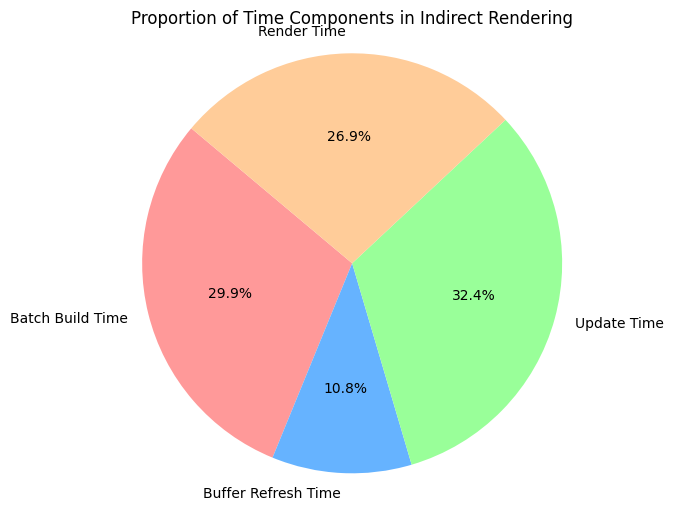

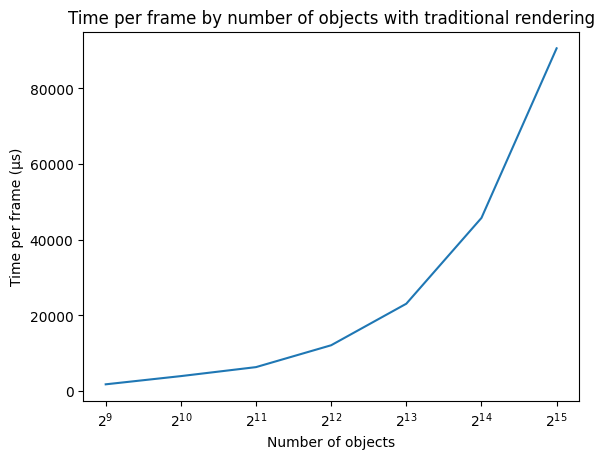

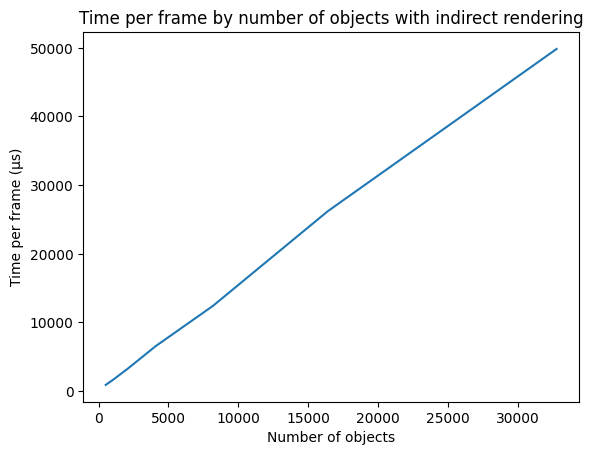

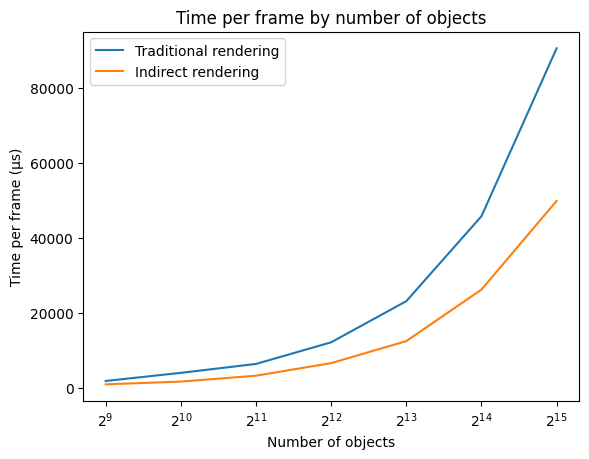

In [258]:
ms_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingMeshObjects")

ms_changing_traditional_contexts = filter_contexts(ms_changing_contexts, "ObjectRenderingMethod", "Traditional")
ms_changing_indirect_contexts = filter_contexts(ms_changing_contexts, "ObjectRenderingMethod", "Indirect")

ms_changing_traditional_results = get_merged_contexts_results(ms_changing_traditional_contexts, "NumberOfObjects")
ms_changing_indirect_results = get_merged_contexts_results(ms_changing_indirect_contexts, "NumberOfObjects")

ms_traditional_avg = ms_changing_traditional_results.groupby("NumberOfObjects").mean()
ms_indirect_avg = ms_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(ms_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(ms_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(ms_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(ms_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(ms_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(ms_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(ms_indirect_avg, "FPS", 1_000_000, "FrameTime")

print(no_indirect_avg["BatchBuildTime"].mean())

# Calculate the mean times for the components of indirect rendering
batch_time = ms_indirect_avg["BatchBuildTime"].mean()
buffer_time = ms_indirect_avg["BufferRefreshTime"].mean()
update_time = ms_indirect_avg["UpdateTime"].mean()
render_time = ms_indirect_avg["IndirectSceneRenderTime"].mean()

labels = ["Batch Build Time", "Buffer Refresh Time", "Update Time", "Render Time"]
sizes = [batch_time, buffer_time, update_time, render_time]
colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Time Components in Indirect Rendering")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


generate_line_plot([ms_traditional_avg],
                   "FrameTime",
                   ["Traditional rendering"],
                   "Time per frame by number of objects with traditional rendering",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

generate_line_plot([ms_indirect_avg],
                   "FrameTime",
                   ["Indirect rendering"],
                   "Time per frame by number of objects with indirect rendering",
                   "Number of objects",
                   "Time per frame (μs)")

generate_line_plot([ms_traditional_avg, ms_indirect_avg],
                   "FrameTime",
                   ["Traditional rendering", "Indirect rendering"],
                   "Time per frame by number of objects",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

### Material Changing Objects

3.9752609752609755


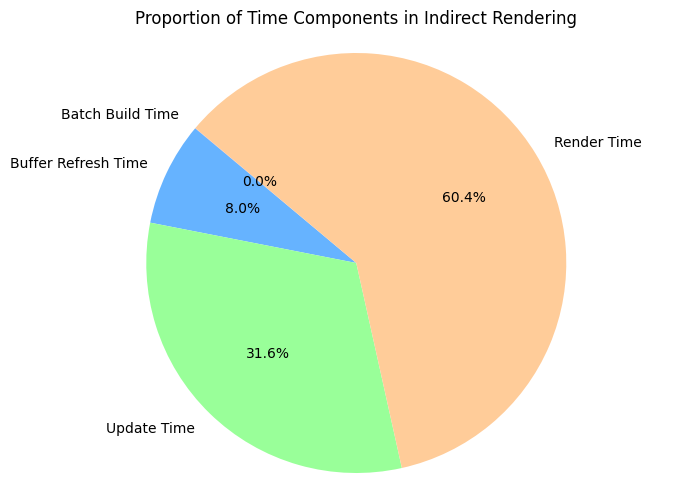

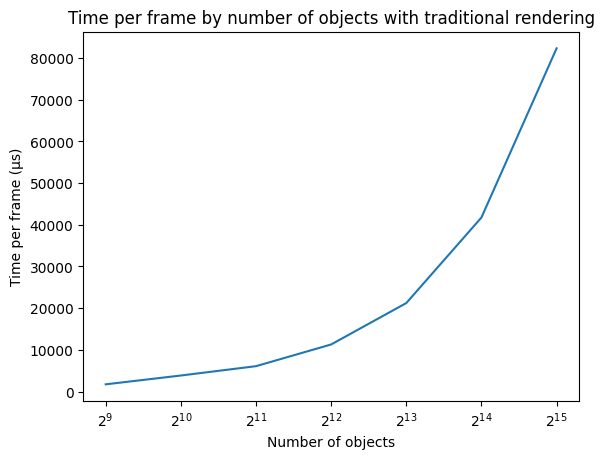

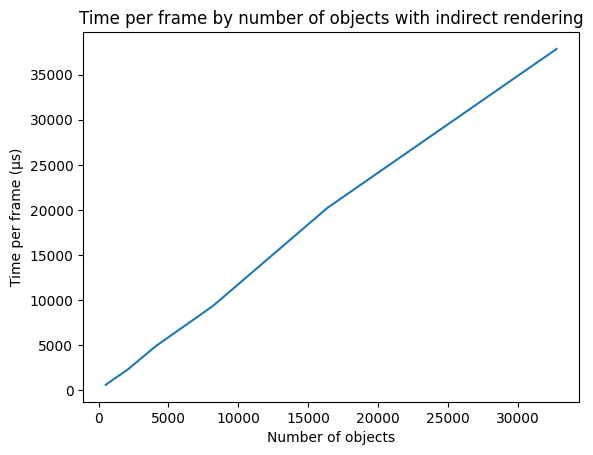

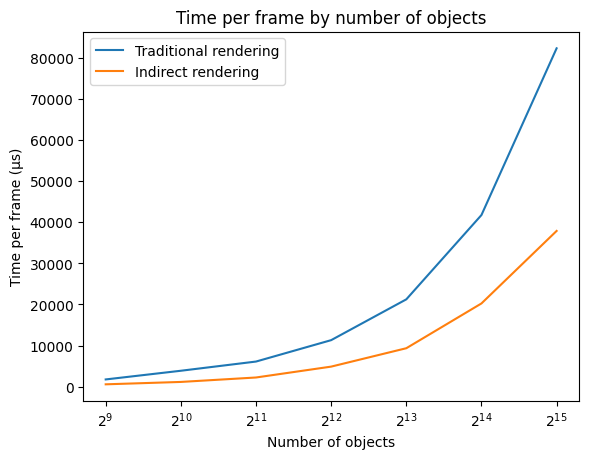

In [259]:
ma_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingMaterialObjects")

ma_changing_traditional_contexts = filter_contexts(ma_changing_contexts, "ObjectRenderingMethod", "Traditional")
ma_changing_indirect_contexts = filter_contexts(ma_changing_contexts, "ObjectRenderingMethod", "Indirect")

ma_changing_traditional_results = get_merged_contexts_results(ma_changing_traditional_contexts, "NumberOfObjects")
ma_changing_indirect_results = get_merged_contexts_results(ma_changing_indirect_contexts, "NumberOfObjects")

ma_traditional_avg = ma_changing_traditional_results.groupby("NumberOfObjects").mean()
ma_indirect_avg = ma_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(ma_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(ma_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(ma_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(ma_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(ma_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(ma_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(ma_indirect_avg, "FPS", 1_000_000, "FrameTime")

print(no_indirect_avg["BatchBuildTime"].mean())

# Calculate the mean times for the components of indirect rendering
batch_time = ma_indirect_avg["BatchBuildTime"].mean()
buffer_time = ma_indirect_avg["BufferRefreshTime"].mean()
update_time = ma_indirect_avg["UpdateTime"].mean()
render_time = ma_indirect_avg["IndirectSceneRenderTime"].mean()

labels = ["Batch Build Time", "Buffer Refresh Time", "Update Time", "Render Time"]
sizes = [batch_time, buffer_time, update_time, render_time]
colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Time Components in Indirect Rendering")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


generate_line_plot([ma_traditional_avg],
                   "FrameTime",
                   ["Traditional rendering"],
                   "Time per frame by number of objects with traditional rendering",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

generate_line_plot([ma_indirect_avg],
                   "FrameTime",
                   ["Indirect rendering"],
                   "Time per frame by number of objects with indirect rendering",
                   "Number of objects",
                   "Time per frame (μs)")

generate_line_plot([ma_traditional_avg, ma_indirect_avg],
                   "FrameTime",
                   ["Traditional rendering", "Indirect rendering"],
                   "Time per frame by number of objects",
                   "Number of objects",
                   "Time per frame (μs)",
                   True)

In [249]:
raise Exception("get_merged_contexts_results: no contexts provided") 

N_values = indirect_avg.index
batch_build_times = indirect_avg["BatchBuildTime"]
buffer_refresh_times = indirect_avg["BufferRefreshTime"]
indirect_scene_render_times = indirect_avg["IndirectSceneRenderTime"]

bar_width = 0.25
bar1 = np.arange(len(N_values))
bar2 = [x + bar_width for x in bar1]
bar3 = [x + bar_width for x in bar2]

plt.bar(bar1, batch_build_times, color='r', width=bar_width, edgecolor='grey', label="Batches build time")
plt.bar(bar2, buffer_refresh_times, color='g', width=bar_width, edgecolor='grey', label="Buffers refresh time")
plt.bar(bar3, indirect_scene_render_times, color='b', width=bar_width, edgecolor='grey', label="Render time")

# Set labels and title
plt.xlabel("Number of objects")
plt.ylabel("Time (μs)")
plt.title("Indirect rendering times by number of objects")
plt.xticks([r + bar_width for r in range(len(N_values))], N_values)
plt.legend()

#display(HTML(traditional_avg.to_html()))
#display(HTML(indirect_avg.to_html()))

##
## BAR FRAME TIME PLOT
##

bar_width = 0.25
bar1 = np.arange(len(traditional_avg.index))
bar2 = [x + bar_width for x in bar1]

# Frame Time Bar Chart
fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FrameTime"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FrameTime"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Time per frame (μs)")
ax.set_title("Time per frame by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()

##
## BAR FPS PLOT
##

fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FPS"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FPS"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Frames per second")
ax.set_title("Frames per second by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()


Exception: get_merged_contexts_results: no contexts provided